In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# File paths
train_dir = "D:\\DocumentsApp\\2025_S\\7545\\project\\archive (1)\\Coronahack-Chest-XRay-Dataset\\Coronahack-Chest-XRay-Dataset\\train"
test_dir = "D:\\DocumentsApp\\2025_S\\7545\\project\\archive (1)\\Coronahack-Chest-XRay-Dataset\\Coronahack-Chest-XRay-Dataset\\test"
metadata_path = "D:\\DocumentsApp\\2025_S\\7545\\project\\archive (1)\\Chest_xray_Corona_Metadata.csv"


In [3]:
# Load metadata
metadata = pd.read_csv(metadata_path)


In [4]:
# Filter for training data only
train_metadata = metadata[metadata['Dataset_type'] == 'TRAIN']

In [7]:
# Define classes (Normal vs Infected)
train_metadata = train_metadata.copy()
train_metadata['class'] = train_metadata['Label'].apply(lambda x: 'Normal' if x == 'Normal' else 'Infected')

In [8]:
# Display class distribution
print("Class distribution in training data:")
print(train_metadata['class'].value_counts())

Class distribution in training data:
class
Infected    3944
Normal      1342
Name: count, dtype: int64


In [9]:
# Function to display sample images
def display_sample_images(metadata, num_samples=5):
    # Infected samples
    infected_samples = metadata[metadata['class'] == 'Infected'].sample(num_samples)
    # Normal samples
    normal_samples = metadata[metadata['class'] == 'Normal'].sample(num_samples)
    
    plt.figure(figsize=(15, 8))
    
    # Display infected images
    for i, (_, row) in enumerate(infected_samples.iterrows()):
        img_path = os.path.join(train_dir, row['X_ray_image_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img)
        plt.title('Infected')
        plt.axis('off')
    
    # Display normal images
    for i, (_, row) in enumerate(normal_samples.iterrows()):
        img_path = os.path.join(train_dir, row['X_ray_image_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(2, num_samples, num_samples+i+1)
        plt.imshow(img)
        plt.title('Normal')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

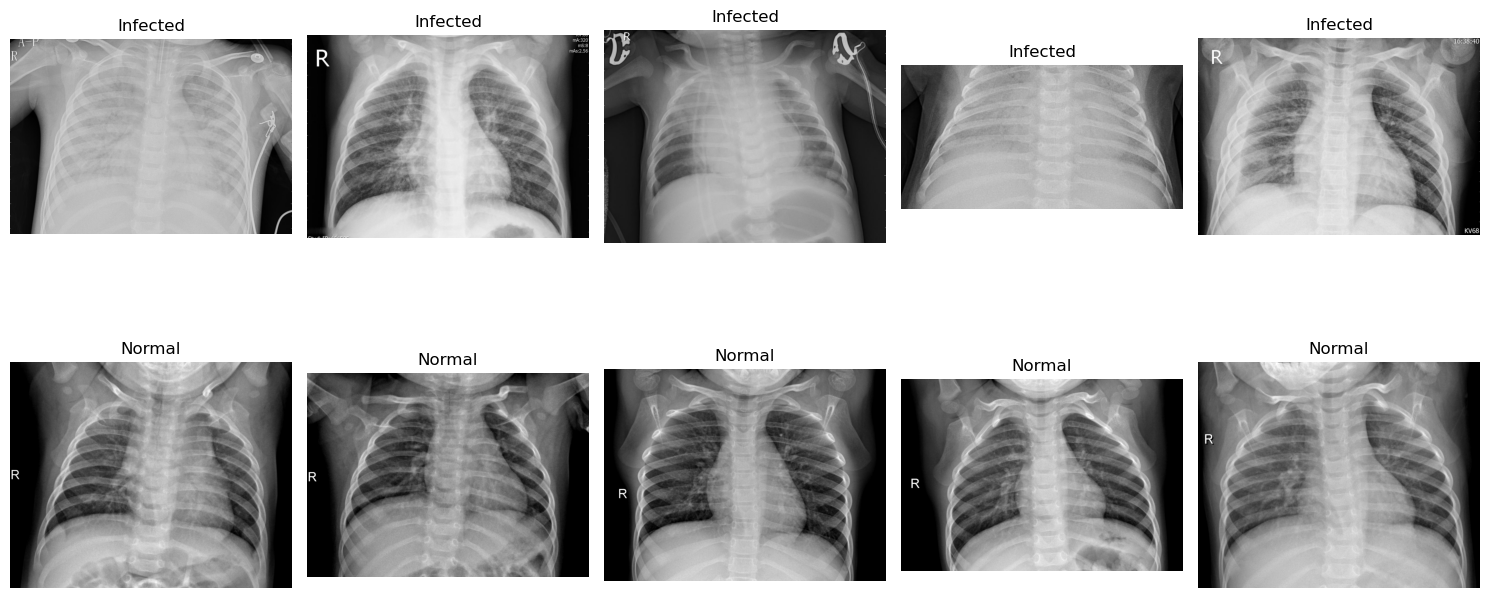

In [10]:
# Display sample images
display_sample_images(train_metadata)

In [11]:
# Image preprocessing function
def preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        return None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize
    return img

In [12]:
# Load and preprocess data
X = []
y = []
for _, row in train_metadata.iterrows():
    img_path = os.path.join(train_dir, row['X_ray_image_name'])
    img = preprocess_image(img_path)
    if img is not None:
        X.append(img)
        y.append(1 if row['class'] == 'Infected' else 0)  # 1 for Infected, 0 for Normal

X = np.array(X)
y = np.array(y)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
# Class balancing
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

model = Sequential([
    Input(shape=(224, 224, 3)), 
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [15]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

In [19]:
steps_per_epoch = len(train_generator)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 84s 631ms/step - accuracy: 0.8526 - loss: 0.3518 - val_accuracy: 0.9093 - val_loss: 0.2273
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 80s 601ms/step - accuracy: 0.8823 - loss: 0.2694 - val_accuracy: 0.7977 - val_loss: 0.4489
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 79s 589ms/step - accuracy: 0.8874 - loss: 0.2425 - val_accuracy: 0.8270 - val_loss: 0.4140
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 76s 568ms/step - accuracy: 0.9015 - loss: 0.2187 - val_accuracy: 0.9026 - val_loss: 0.2498
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 79s 595ms/step - accuracy: 0.8701 - loss: 0.2763 - val_accuracy: 0.8034 - val_loss: 0.4052
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 81s 607ms/step - accuracy: 0.8917 - loss: 0.2445 - val_accuracy: 0.9093 - val_loss: 0.2350


In [20]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Accuracy: {accuracy:.4f}")



Validation Accuracy: 0.9093


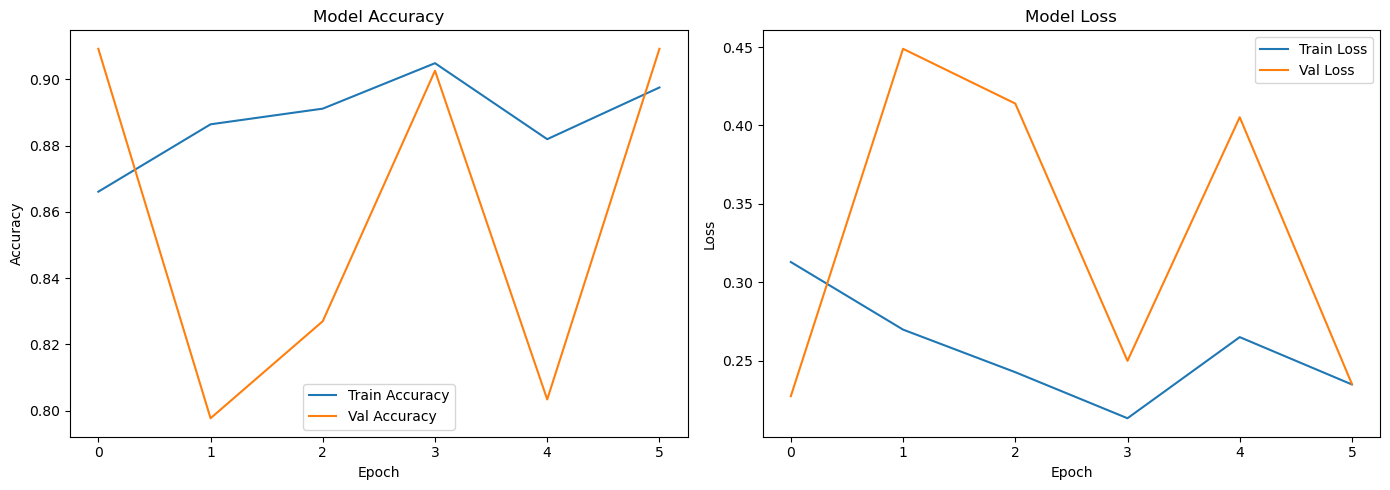

In [21]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(14,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step


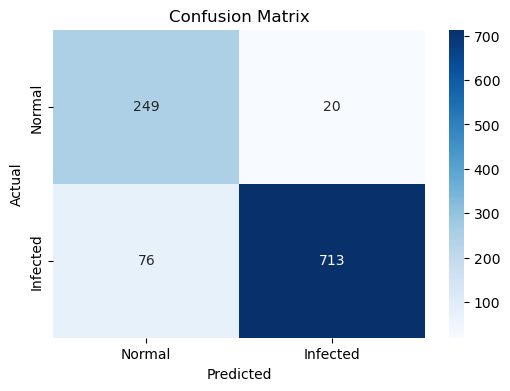


Classification Report:
              precision    recall  f1-score   support

      Normal       0.77      0.93      0.84       269
    Infected       0.97      0.90      0.94       789

    accuracy                           0.91      1058
   macro avg       0.87      0.91      0.89      1058
weighted avg       0.92      0.91      0.91      1058



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on validation set
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Infected'], yticklabels=['Normal', 'Infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Normal', 'Infected']))


In [25]:
# Save model in .keras  format
model.save("chest_xray_model.keras") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


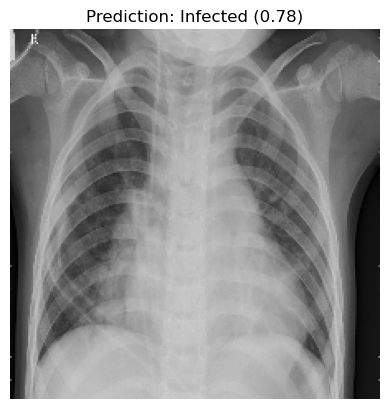

In [27]:
import random

def test_on_random_image(test_dir, model):
    test_images = os.listdir(test_dir)
    selected_img = random.choice(test_images)
    img_path = os.path.join(test_dir, selected_img)
    img = preprocess_image(img_path)
    
    if img is not None:
        img_batch = np.expand_dims(img, axis=0)
        prediction = model.predict(img_batch)[0][0]
        label = 'Infected' if prediction > 0.5 else 'Normal'
        
        plt.imshow(img)
        plt.title(f'Prediction: {label} ({prediction:.2f})')
        plt.axis('off')
        plt.show()
    else:
        print("Couldn't read the image.")

# Test on random image from test directory
test_on_random_image(test_dir, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


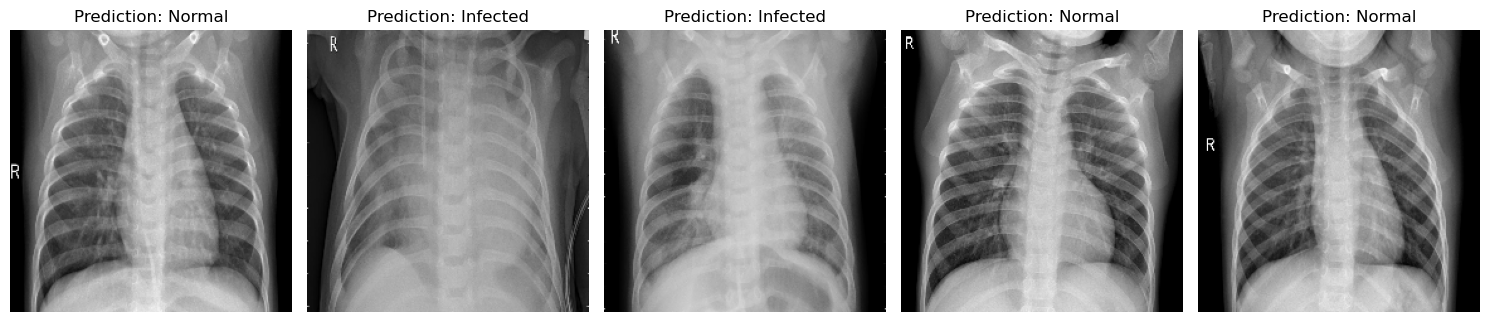

In [29]:
import random

def test_random_images(test_dir, model, num_images=5):
    test_images = os.listdir(test_dir)
    selected_images = random.sample(test_images, num_images)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(test_dir, img_name)
        img = preprocess_image(img_path)
        if img is not None:
            pred = model.predict(np.expand_dims(img, axis=0))[0][0]
            label = 'Infected' if pred > 0.5 else 'Normal'

            plt.subplot(1, num_images, i+1)
            plt.imshow(img)
            plt.title(f"Prediction: {label}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# test 
test_random_images(test_dir, model)


In [31]:
# --------------------VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

# Load VGG16 without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Final model
model_vgg = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_vgg.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
history_vgg = model_vgg.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the model
model_vgg.save('vgg16_chest_xray_model.keras')

# Evaluate the model performance
loss, acc = model_vgg.evaluate(X_val, y_val, verbose=0)
print(f"✅ VGG16 Accuracy on Validation Set: {acc:.4f}")


Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.5819 - loss: 0.6837 - val_accuracy: 0.8403 - val_loss: 0.5158
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - accuracy: 0.7820 - loss: 0.5006 - val_accuracy: 0.8176 - val_loss: 0.4617
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 397s 3s/step - accuracy: 0.8525 - loss: 0.3901 - val_accuracy: 0.8497 - val_loss: 0.3770
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 387s 3s/step - accuracy: 0.8826 - loss: 0.3286 - val_accuracy: 0.8450 - val_loss: 0.3700
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - accuracy: 0.8754 - loss: 0.3061 - val_accuracy: 0.8535 - val_loss: 0.3443
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 408s 3s/step - accuracy: 0.8840 - loss: 0.2820 - val_accuracy: 0.8299 - val_loss: 0.3965
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.8910 - loss: 0.2776 - val_accuracy: 0.8724 - val_loss: 0.3120
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 395s 3s/step - accuracy: 0.8943 - loss: 0.2559 - val_accu

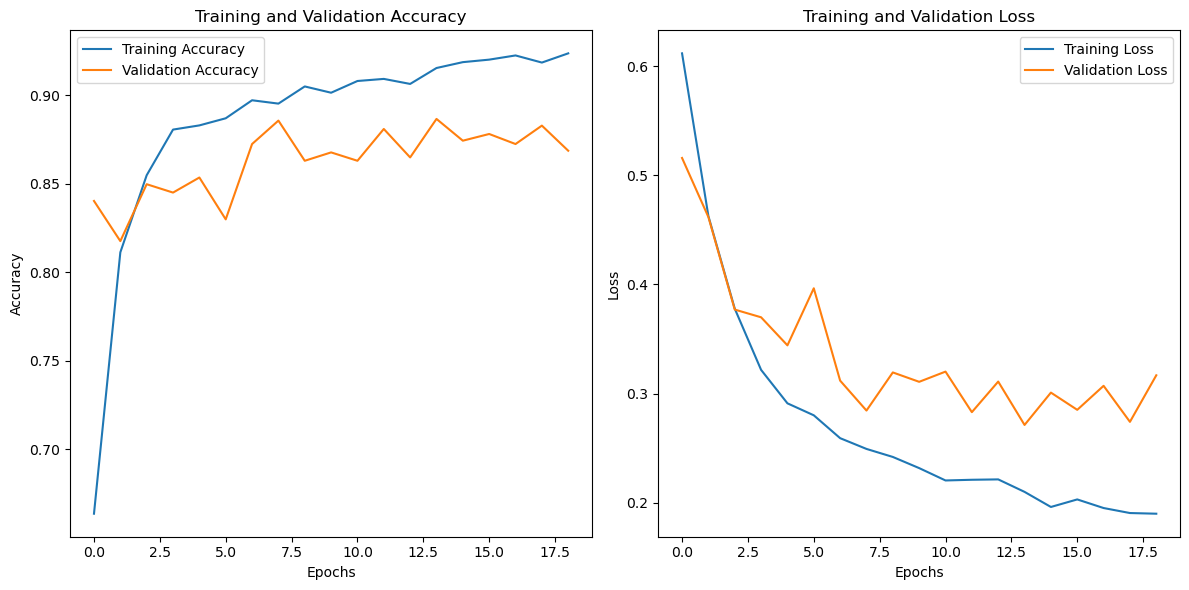

In [32]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


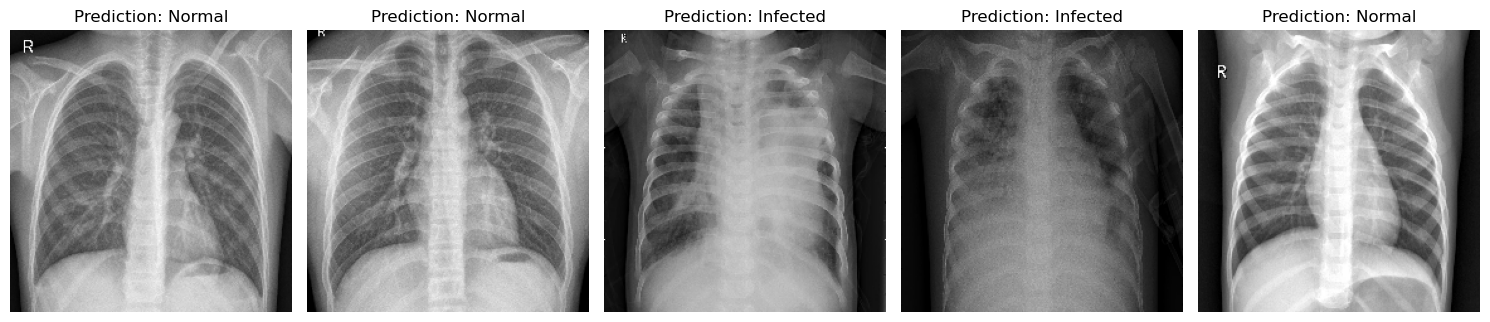

In [35]:
import random
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image

# Assuming 'preprocess_image' is already defined as in your previous code

def preprocess_image_test(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize to [0, 1]
    return img

def test_random_images(test_dir, model, num_images=5):
    test_images = os.listdir(test_dir)
    selected_images = random.sample(test_images, num_images)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(test_dir, img_name)
        img = preprocess_image_test(img_path)
        if img is not None:
            # Predict the class using the model
            pred = model.predict(img)[0][0]  # Model output for binary classification (single value)
            label = 'Infected' if pred > 0.5 else 'Normal'  # Threshold at 0.5

            plt.subplot(1, num_images, i+1)
            img_display = image.load_img(img_path, target_size=(224, 224))
            plt.imshow(img_display)
            plt.title(f"Prediction: {label}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Test with random images from the test directory
test_random_images(test_dir, model)


In [38]:
# ----------------- MobileNetV2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pool the features into a single vector
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,914,369 (11.12 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [39]:
# Data augmentation and training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_mobilenetv2_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)


C:\ProgramData\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 69s 495ms/step - accuracy: 0.8212 - loss: 0.3729 - val_accuracy: 0.9386 - val_loss: 0.1632
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 67s 501ms/step - accuracy: 0.9357 - loss: 0.1605 - val_accuracy: 0.9537 - val_loss: 0.1353
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 64s 478ms/step - accuracy: 0.9400 - loss: 0.1511 - val_accuracy: 0.9556 - val_loss: 0.1226
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 63s 474ms/step - accuracy: 0.9457 - loss: 0.1316 - val_accuracy: 0.9546 - val_loss: 0.1154
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 63s 471ms/step - accuracy: 0.9469 - loss: 0.1268 - val_accuracy: 0.9433 - val_loss: 0.1423
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 63s 470ms/step - accuracy: 0.9408 - loss: 0.1344 - val_accuracy: 0.9452 - val_loss: 0.1323
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 66s 495ms/step - accuracy: 0.9505 - loss: 0.1171 - val_accuracy: 0.9584 - val_loss: 0.1110
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 71s 535ms/step - accuracy: 0.9553 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


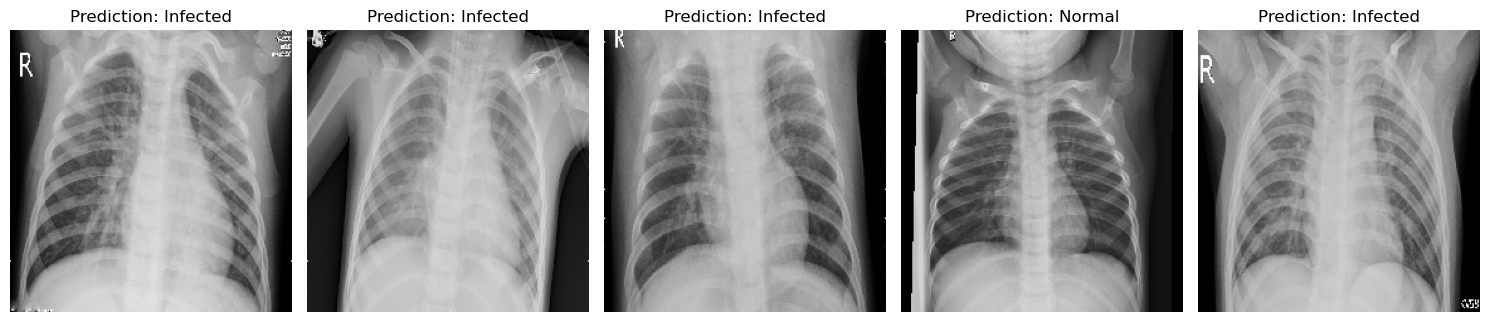

In [40]:
# Test random images using MobileNetV2 model
test_random_images(test_dir, model)


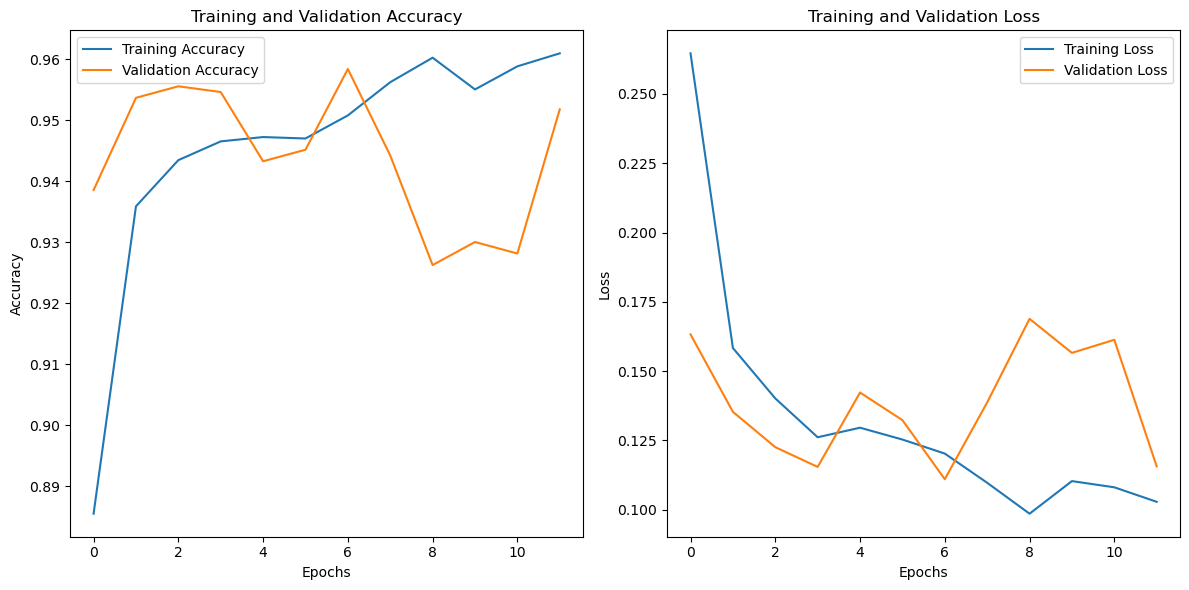

In [41]:
import matplotlib.pyplot as plt

# Training History
def plot_accuracy_and_loss(history):
    # Plot Training & Validation Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the accuracy and loss curves
plot_accuracy_and_loss(history)


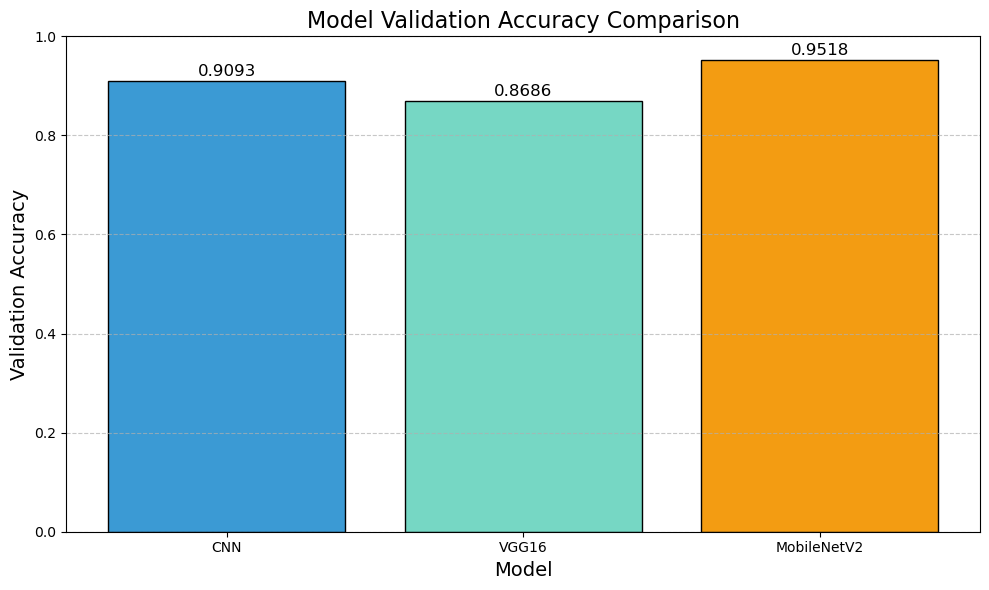

In [53]:
import matplotlib.pyplot as plt

accuracy_cnn = 0.9093
accuracy_vgg = 0.8686
accuracy_mobilenetv2 = 0.9518

models = ['CNN', 'VGG16', 'MobileNetV2']
accuracies = [accuracy_cnn, accuracy_vgg, accuracy_mobilenetv2]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['#3b9ad4', '#76d7c4', '#f39c12'], edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 4), ha='center', va='bottom', fontsize=12)

plt.xlabel('Model', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.title('Model Validation Accuracy Comparison', fontsize=16)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()
